# Sistema de detecção de cubos e esferas - YOLOv11s

## Sistema Completo de Treinamento

Sumário do notebook:
- Baixar dataset do Roboflow
- Separar em train/val/test customizado
- Treinar YOLOv11s
- Validar e testar o modelo
- Fazer inferência

---

**Dataset Usado:** 3d geom shape detector (1600 imagens)  
**Fonte:** [Roboflow Universe](https://universe.roboflow.com/w0/3d-geom-shape-detector)

---

## 1- Setup Inicial

### Instalar Dependências

### Imports

In [10]:
from roboflow import Roboflow
from ultralytics import YOLO
from pathlib import Path
import shutil
import random
import yaml
import cv2
import matplotlib.pyplot as plt
from IPython.display import Image, display

print("✅ Imports carregados!")

✅ Imports carregados!


## 2- Configurações

### Configure seus parâmetros aqui:

In [11]:

API_KEY = "RGZ4JUpt6YMS1ZreoZAT"

WORKSPACE = "w0"
PROJECT = "3d-geom-shape-detector"
VERSION = 1

TRAIN_PCT = 70   # Treino
VAL_PCT = 20     # Validação
TEST_PCT = 10    # Teste

OUTPUT_DIR = "dataset_custom_split"  # Onde salvar o dataset

EPOCHS = 100
BATCH_SIZE = 16
IMG_SIZE = 640
MODEL = "yolo11s"

import torch
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# =============================================================================

print("="*70)
print("⚙️  CONFIGURAÇÕES")
print("="*70)
print(f"Dataset: {WORKSPACE}/{PROJECT}")
print(f"Splits: {TRAIN_PCT}% / {VAL_PCT}% / {TEST_PCT}%")
print(f"Épocas: {EPOCHS}")
print(f"Batch: {BATCH_SIZE}")
print(f"Device: {DEVICE}")
print(f"Modelo: {MODEL}")
print("="*70)

⚙️  CONFIGURAÇÕES
Dataset: w0/3d-geom-shape-detector
Splits: 70% / 20% / 10%
Épocas: 100
Batch: 16
Device: cpu
Modelo: yolo11s


## 3- Download e Preparação do Dataset

### Baixar e Separar em Train/Val/Test

In [12]:
def download_and_split_dataset(
    api_key,
    workspace,
    project,
    version=1,
    train_pct=70,
    val_pct=20,
    test_pct=10,
    output_dir="dataset_split"
):
    """
    Baixa dataset do Roboflow e separa em train/val/test
    """

    print("="*70)
    print("BAIXANDO DATASET DO ROBOFLOW")
    print("="*70)

    rf = Roboflow(api_key=api_key)

    print(f"\nAcessando: {workspace}/{project} v{version}")
    project_obj = rf.workspace(workspace).project(project)

    print(f"\n Baixando dataset...")
    dataset = project_obj.version(version).download("yolov8")

    print(f"\n Download concluído!")
    print(f" Localização temporária: {dataset.location}")

    print(f"\n Coletando arquivos...")
    dataset_path = Path(dataset.location)

    all_files = []

    for split_dir in ['train', 'valid', 'test']:
        img_dir = dataset_path / split_dir / 'images'
        lbl_dir = dataset_path / split_dir / 'labels'

        if img_dir.exists() and lbl_dir.exists():
            for img_file in img_dir.glob('*.*'):
                if img_file.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                    lbl_file = lbl_dir / (img_file.stem + '.txt')

                    if lbl_file.exists():
                        all_files.append({
                            'image': img_file,
                            'label': lbl_file
                        })

    print(f" Total de arquivos: {len(all_files)}")

    total = train_pct + val_pct + test_pct
    if abs(total - 100) > 0.1:
        factor = 100 / total
        train_pct *= factor
        val_pct *= factor
        test_pct *= factor

    random.seed(42)
    random.shuffle(all_files)

    n_total = len(all_files)
    n_train = int(n_total * train_pct / 100)
    n_val = int(n_total * val_pct / 100)
    n_test = n_total - n_train - n_val

    print(f"\n SEPARAÇÃO:")
    print(f"   Treino: {n_train} ({n_train/n_total*100:.1f}%)")
    print(f"   Validação: {n_val} ({n_val/n_total*100:.1f}%)")
    print(f"   Teste: {n_test} ({n_test/n_total*100:.1f}%)")

    train_files = all_files[:n_train]
    val_files = all_files[n_train:n_train+n_val]
    test_files = all_files[n_train+n_val:]

    output_path = Path(output_dir)

    for split in ['train', 'val', 'test']:
        (output_path / split / 'images').mkdir(parents=True, exist_ok=True)
        (output_path / split / 'labels').mkdir(parents=True, exist_ok=True)

    print(f"\n Criando dataset em: {output_path}")

    for split_name, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        print(f"\n Copiando {split_name}... ({len(files)} arquivos)")

        for item in files:
            img_dest = output_path / split_name / 'images' / item['image'].name
            shutil.copy2(item['image'], img_dest)

            lbl_dest = output_path / split_name / 'labels' / item['label'].name
            shutil.copy2(item['label'], lbl_dest)

    original_yaml = dataset_path / 'data.yaml'
    if original_yaml.exists():
        with open(original_yaml) as f:
            original_config = yaml.safe_load(f)
            class_names = original_config.get('names', ['cube', 'sphere'])
    else:
        class_names = ['cube', 'sphere']

    config = {
        'path': str(output_path.absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': len(class_names),
        'names': class_names
    }

    yaml_path = output_path / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(config, f, default_flow_style=False)

    print(f"\n DATASET PRONTO!")
    print(f" Localização: {output_path}")
    print(f"  Classes ({len(class_names)}): {class_names}")

    try:
        shutil.rmtree(dataset_path)
    except:
        pass

    return str(output_path), class_names

dataset_path, class_names = download_and_split_dataset(
    api_key=API_KEY,
    workspace=WORKSPACE,
    project=PROJECT,
    version=VERSION,
    train_pct=TRAIN_PCT,
    val_pct=VAL_PCT,
    test_pct=TEST_PCT,
    output_dir=OUTPUT_DIR
)

print("\n" + "="*70)
print(" DATASET PREPARADO")
print("="*70)

BAIXANDO DATASET DO ROBOFLOW

Acessando: w0/3d-geom-shape-detector v1
loading Roboflow workspace...
loading Roboflow project...

 Baixando dataset...



Extracting Dataset Version Zip to 3d-geom-shape-detector-1 in yolov8:: 100%|██████████| 2644/2644 [00:01<00:00, 2407.98it/s]



 Download concluído!
 Localização temporária: c:\Users\bruna.cruz\Desktop\Projeto_FigurePicker\yolov11\3d-geom-shape-detector-1

 Coletando arquivos...
 Total de arquivos: 1319

 SEPARAÇÃO:
   Treino: 923 (70.0%)
   Validação: 263 (19.9%)
   Teste: 133 (10.1%)

 Criando dataset em: dataset_custom_split

 Copiando train... (923 arquivos)

 Copiando val... (263 arquivos)

 Copiando test... (133 arquivos)

 DATASET PRONTO!
 Localização: dataset_custom_split
  Classes (9): ['Cube-silicone', 'ball', 'blue_cube', 'circle', 'green_cube', 'rectangle', 'red_cube', 'triangle', 'yellow_cube']

 DATASET PREPARADO


###  Visualizar Amostras do Dataset

 Visualizando amostras do dataset de treino:
Classes no dataset: ['Cube-silicone', 'ball', 'blue_cube', 'circle', 'green_cube', 'rectangle', 'red_cube', 'triangle', 'yellow_cube']
Total de classes: 9



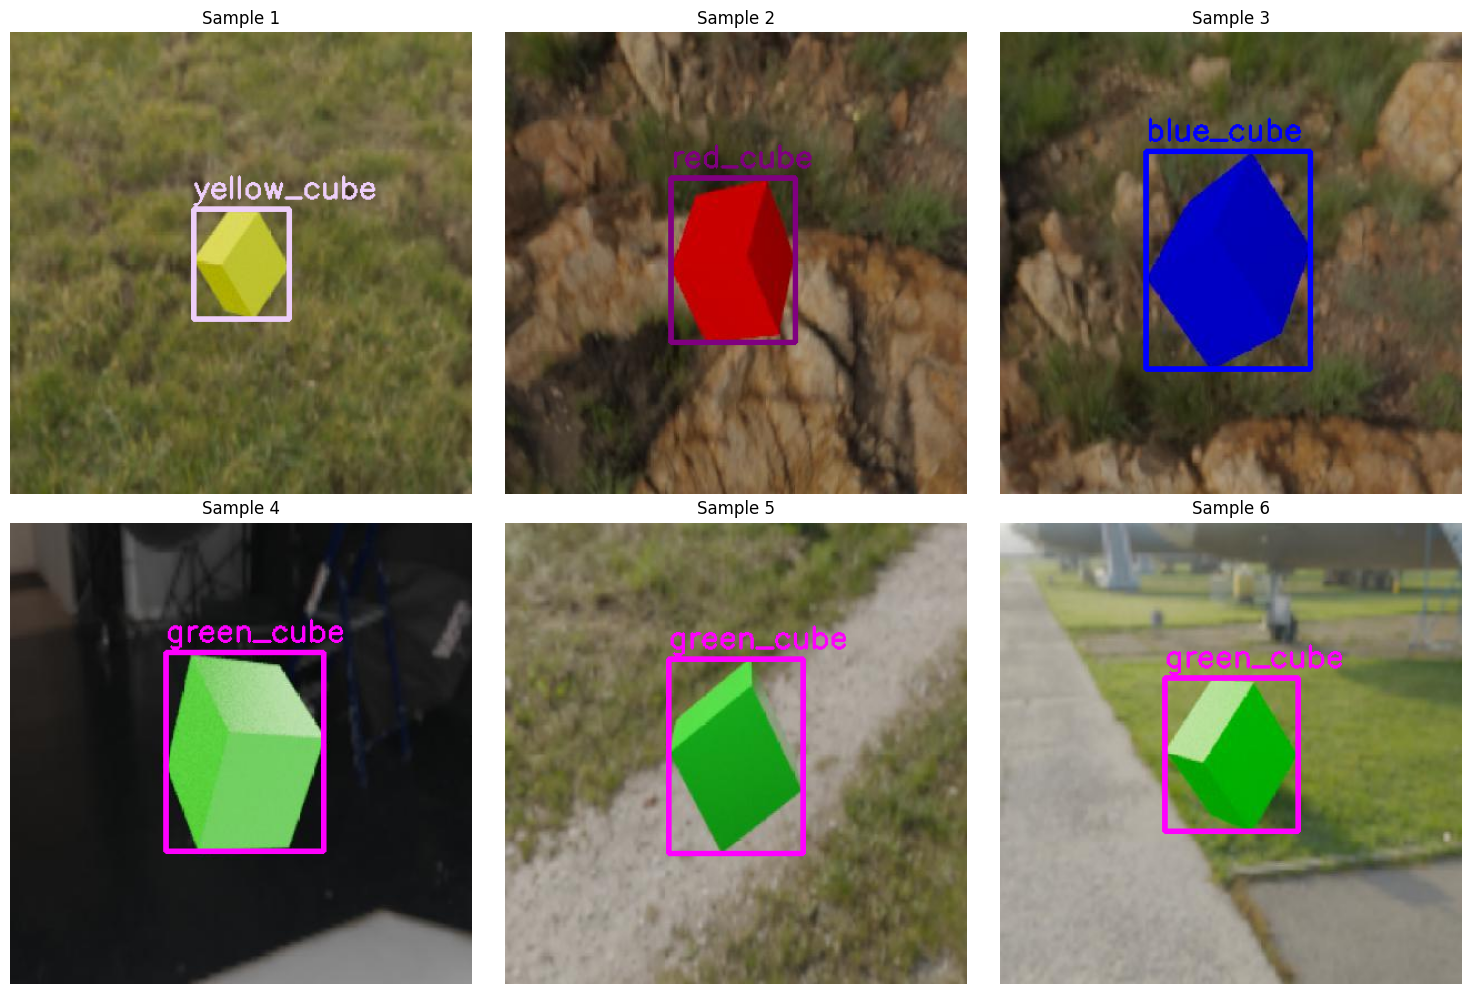

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def visualize_samples(dataset_path, split='train', num_samples=6):
    """
    Visualiza amostras do dataset com bounding boxes
    """
    dataset_path = Path(dataset_path)
    img_dir = dataset_path / split / 'images'
    lbl_dir = dataset_path / split / 'labels'

    images = list(img_dir.glob('*.jpg')) + list(img_dir.glob('*.png'))
    samples = random.sample(images, min(num_samples, len(images)))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    colors_list = [
        (255, 0, 0),    # Vermelho - cube
        (0, 255, 0),    # Verde - sphere
        (0, 0, 255),    # Azul - cylinder
        (255, 255, 0),  # Amarelo - cone
        (255, 0, 255),  # Magenta
        (0, 255, 255),  # Ciano
        (128, 0, 128),  # Roxo
        (255, 165, 0),  # Laranja
    ]

    num_classes = len(class_names)
    while len(colors_list) < num_classes:
        colors_list.append((
            random.randint(100, 255),
            random.randint(100, 255),
            random.randint(100, 255)
        ))

    for idx, img_path in enumerate(samples):
        if idx >= len(axes):
            break

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        label_path = lbl_dir / (img_path.stem + '.txt')

        if label_path.exists():
            with open(label_path) as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 5:
                        class_id = int(parts[0])
                        x_center = float(parts[1]) * w
                        y_center = float(parts[2]) * h
                        width = float(parts[3]) * w
                        height = float(parts[4]) * h

                        x1 = int(x_center - width/2)
                        y1 = int(y_center - height/2)
                        x2 = int(x_center + width/2)
                        y2 = int(y_center + height/2)

                        color = colors_list[class_id] if class_id < len(colors_list) else (255, 255, 255)

                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 3)

                        label = class_names[class_id] if class_id < len(class_names) else f"Class {class_id}"
                        cv2.putText(img, label, (x1, y1-10),
                                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

        axes[idx].imshow(img)
        axes[idx].set_title(f"Sample {idx+1}")
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

print(" Visualizando amostras do dataset de treino:")
print(f"Classes no dataset: {class_names}")
print(f"Total de classes: {len(class_names)}\n")
visualize_samples(dataset_path, split='train', num_samples=6)


## 4️- Filtrando dataset

### Apenas cubos e esferas (dataset original possui 9 classes)

In [14]:
print("="*70)
print("FILTRANDO DATASET - APENAS CUBOS E ESFERAS")
print("="*70)

from pathlib import Path
import shutil
import yaml

def filter_cubes_spheres(dataset_path, output_path="dataset_filtered"):
    dataset_path = Path(dataset_path)
    output_path = Path(output_path)

    yaml_path = dataset_path / 'data.yaml'
    with open(yaml_path) as f:
        config = yaml.safe_load(f)

    original_classes = config['names']
    print(f"\nClasses originais: {original_classes}")
    print(f"   Total: {len(original_classes)} classes")

    cube_ids = []      # Todas as classes com 'cube' (exceto cuboid)
    sphere_ids = []    # Todas as classes com 'ball', 'sphere' ou 'circle'

    print(f"\n Identificando classes...")
    
    for idx, class_name in enumerate(original_classes):
        class_lower = class_name.lower()
        
        if 'cube' in class_lower and 'cuboid' not in class_lower:
            cube_ids.append(idx)
            print(f"   ✅ CUBE: ID {idx} -> '{class_name}'")
        
        elif 'sphere' in class_lower or 'ball' in class_lower or 'circle' in class_lower:
            sphere_ids.append(idx)
            print(f"   ✅ SPHERE: ID {idx} -> '{class_name}'")
        
        else:
            print(f"   ❌ IGNORADO: ID {idx} -> '{class_name}'")

    if not cube_ids:
        print(f"\n⚠️ Nenhuma classe de CUBE encontrada!")
        print(f"   Procurado: 'cube' (excluindo 'cuboid')")
    
    if not sphere_ids:
        print(f"\n⚠️ Nenhuma classe de SPHERE encontrada!")
        print(f"   Procurado: 'sphere', 'ball', 'circle'")

    if not cube_ids and not sphere_ids:
        print(f"\n❌ Erro: Nenhuma classe relevante encontrada!")
        return None

    print(f"\n Resumo das classes identificadas:")
    print(f"   CUBES ({len(cube_ids)} classes): {[original_classes[i] for i in cube_ids]}")
    print(f"   SPHERES ({len(sphere_ids)} classes): {[original_classes[i] for i in sphere_ids]}")

    final_mapping = {}
    
    for cube_id in cube_ids:
        final_mapping[cube_id] = 0  # Todas viram 'cube' (classe 0)
    
    for sphere_id in sphere_ids:
        final_mapping[sphere_id] = 1  # Todas viram 'sphere' (classe 1)

    print(f"\n Mapeamento de IDs:")
    for old_id, new_id in sorted(final_mapping.items()):
        new_name = 'cube' if new_id == 0 else 'sphere'
        print(f"   {original_classes[old_id]} ({old_id}) → {new_name} ({new_id})")

    keep_ids = set(cube_ids + sphere_ids)

    stats = {
        'total_images': 0,
        'kept_images': 0,
        'removed_images': 0,
        'circle_mixed_removed': 0,  # Imagens com circle + outro objeto não-relevante
        'cube_count': 0,
        'sphere_count': 0,
        'cube_sources': {original_classes[i]: 0 for i in cube_ids},
        'sphere_sources': {original_classes[i]: 0 for i in sphere_ids}
    }

    for split in ['train', 'val', 'test']:
        img_dir = dataset_path / split / 'images'
        lbl_dir = dataset_path / split / 'labels'

        if not img_dir.exists():
            print(f"\n Diretório não encontrado: {img_dir}")
            continue

        out_img_dir = output_path / split / 'images'
        out_lbl_dir = output_path / split / 'labels'
        out_img_dir.mkdir(parents=True, exist_ok=True)
        out_lbl_dir.mkdir(parents=True, exist_ok=True)

        print(f"\n Processando {split}...")

        for img_file in img_dir.glob('*.*'):
            if img_file.suffix.lower() not in ['.jpg', '.jpeg', '.png', '.bmp', '.webp']:
                continue

            stats['total_images'] += 1

            lbl_file = lbl_dir / (img_file.stem + '.txt')

            if not lbl_file.exists():
                continue

            new_labels = []
            all_class_ids_in_image = []  # Todos os IDs presentes na imagem
            has_circle = False
            
            with open(lbl_file) as f:
                lines = f.readlines()
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:
                    class_id = int(parts[0])
                    all_class_ids_in_image.append(class_id)
                    
                    if class_id in sphere_ids and 'circle' in original_classes[class_id].lower():
                        has_circle = True
            
            if has_circle:
                non_relevant_ids = [cid for cid in all_class_ids_in_image if cid not in keep_ids]
                if non_relevant_ids:
                    stats['removed_images'] += 1
                    stats['circle_mixed_removed'] += 1
                    continue
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) >= 5:  # class_id + 4 coords (bbox) ou mais (segmentação)
                    class_id = int(parts[0])

                    if class_id in keep_ids:
                        new_id = final_mapping[class_id]
                        new_labels.append(f"{new_id} {' '.join(parts[1:])}")

                        if new_id == 0:
                            stats['cube_count'] += 1
                            stats['cube_sources'][original_classes[class_id]] += 1
                        else:
                            stats['sphere_count'] += 1
                            stats['sphere_sources'][original_classes[class_id]] += 1

            if new_labels:
                shutil.copy2(img_file, out_img_dir / img_file.name)

                with open(out_lbl_dir / (img_file.stem + '.txt'), 'w') as f:
                    f.write('\n'.join(new_labels) + '\n')

                stats['kept_images'] += 1
            else:
                stats['removed_images'] += 1

    new_config = {
        'path': str(output_path.absolute()),
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 2,
        'names': ['cube', 'sphere']
    }

    new_yaml_path = output_path / 'data.yaml'
    with open(new_yaml_path, 'w') as f:
        yaml.dump(new_config, f, default_flow_style=False)

    print(f"\n" + "="*70)
    print(" ESTATÍSTICAS DA FILTRAGEM")
    print("="*70)
    
    print(f"\n Imagens:")
    print(f"   Total original: {stats['total_images']}")
    print(f"   Mantidas: {stats['kept_images']}")
    print(f"   Removidas: {stats['removed_images']}")
    if stats['circle_mixed_removed'] > 0:
        print(f"      └─ Circle + outro objeto: {stats['circle_mixed_removed']}")
    if stats['total_images'] > 0:
        print(f"   % mantido: {stats['kept_images']/stats['total_images']*100:.1f}%")

    print(f"\n Objetos detectados:")
    print(f"   Cubos (total): {stats['cube_count']}")
    for source, count in stats['cube_sources'].items():
        if count > 0:
            print(f"      └─ {source}: {count}")
    
    print(f"   Esferas (total): {stats['sphere_count']}")
    for source, count in stats['sphere_sources'].items():
        if count > 0:
            print(f"      └─ {source}: {count}")
    
    print(f"   Total geral: {stats['cube_count'] + stats['sphere_count']}")

    print(f"\n Dataset filtrado salvo em: {output_path}")
    print(f" Configuração: {new_yaml_path}")

    return str(output_path)



filtered_dataset_path = filter_cubes_spheres(
    dataset_path=dataset_path,
    output_path="dataset_filtered"
)

if filtered_dataset_path:
    dataset_path = filtered_dataset_path

    print(f"\n" + "="*70)
    print("✅ FILTRAGEM CONCLUÍDA!")
    print("="*70)
    print(f"\n O treinamento agora usará apenas CUBOS e ESFERAS")
    print(f" Novo dataset: {dataset_path}")
else:
    print(f"\n" + "="*70)
    print("❌ ERRO NA FILTRAGEM")
    print("="*70)
    print(f"\n O treinamento usará o dataset completo")

FILTRANDO DATASET - APENAS CUBOS E ESFERAS

Classes originais: ['Cube-silicone', 'ball', 'blue_cube', 'circle', 'green_cube', 'rectangle', 'red_cube', 'triangle', 'yellow_cube']
   Total: 9 classes

 Identificando classes...
   ✅ CUBE: ID 0 -> 'Cube-silicone'
   ✅ SPHERE: ID 1 -> 'ball'
   ✅ CUBE: ID 2 -> 'blue_cube'
   ✅ SPHERE: ID 3 -> 'circle'
   ✅ CUBE: ID 4 -> 'green_cube'
   ❌ IGNORADO: ID 5 -> 'rectangle'
   ✅ CUBE: ID 6 -> 'red_cube'
   ❌ IGNORADO: ID 7 -> 'triangle'
   ✅ CUBE: ID 8 -> 'yellow_cube'

 Resumo das classes identificadas:
   CUBES (5 classes): ['Cube-silicone', 'blue_cube', 'green_cube', 'red_cube', 'yellow_cube']
   SPHERES (2 classes): ['ball', 'circle']

 Mapeamento de IDs:
   Cube-silicone (0) → cube (0)
   ball (1) → sphere (1)
   blue_cube (2) → cube (0)
   circle (3) → sphere (1)
   green_cube (4) → cube (0)
   red_cube (6) → cube (0)
   yellow_cube (8) → cube (0)

 Processando train...

 Processando val...

 Processando test...

 ESTATÍSTICAS DA FILTRAGEM



In [15]:
print("="*70)
print("🚀 INICIANDO TREINAMENTO")
print("="*70)

from pathlib import Path

filtered_path = Path("dataset_filtered")
if filtered_path.exists():
    dataset_path = "dataset_filtered"
    print(f"\n Usando dataset FILTRADO (apenas cube e sphere)")
    print(f" Caminho: {dataset_path}")

    yaml_path = filtered_path / 'data.yaml'
    if yaml_path.exists():
        import yaml
        with open(yaml_path) as f:
            config = yaml.safe_load(f)
        print(f"  Classes: {config.get('names', [])}")
        print(f" Número de classes: {config.get('nc', 0)}")
else:
    print(f"\n  Dataset filtrado não encontrado")
    print(f" Usando dataset original: {dataset_path}")
    print(f"\n Para treinar apenas com cube e sphere:")
    print(f"   Execute a célula de filtragem antes desta célula")

model = YOLO(f'{MODEL}.pt')

print(f"\n  Configurações de Treinamento:")
print(f"   Modelo: {MODEL}")
print(f"   Dataset: {dataset_path}")
print(f"   Épocas: {EPOCHS}")
print(f"   Batch: {BATCH_SIZE}")
print(f"   Imagem: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Device: {DEVICE}")

print(f"\n Treinando...")
print(f"   (Isso pode levar alguns minutos...)\n")

results = model.train(
    data=f'{dataset_path}/data.yaml',
    epochs=EPOCHS,
    batch=BATCH_SIZE,
    imgsz=IMG_SIZE,
    device=DEVICE,
    project='runs/detect',
    name='cubes_spheres',
    exist_ok=True,
    pretrained=True,
    patience=20,
    save=True,
    plots=True,
    verbose=True
)

print("\n" + "="*70)
print("TREINAMENTO CONCLUÍDO!")
print("="*70)

# Mostrar informações do modelo treinado
print(f"\nResultados salvos em:")
print(f"   runs/detect/cubes_spheres/")
print(f"\n Melhor modelo:")
print(f"   runs/detect/cubes_spheres/weights/best.pt")
print(f"\n Métricas:")
print(f"   runs/detect/cubes_spheres/results.png")

🚀 INICIANDO TREINAMENTO

 Usando dataset FILTRADO (apenas cube e sphere)
 Caminho: dataset_filtered
  Classes: ['cube', 'sphere']
 Número de classes: 2

  Configurações de Treinamento:
   Modelo: yolo11s
   Dataset: dataset_filtered
   Épocas: 100
   Batch: 16
   Imagem: 640x640
   Device: cpu

 Treinando...
   (Isso pode levar alguns minutos...)

Ultralytics 8.3.229  Python-3.10.6 torch-2.9.1+cpu CPU (Intel Core Ultra 9 185H)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset_filtered/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz